In [9]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# common import
import pandas as pd
import torch as ch
import os

In [11]:
# common config settings

RESULT_DIR = './results_new_labeler_paper_written_ver'
QUAL_DIR = f'{RESULT_DIR}/quals'
os.makedirs(QUAL_DIR, exist_ok=True)
RESNET50_PARAM_CONTROL_ACCS_FILE_NAME = '/home/dhahn/ImageNet-ES/results/res50_imagenet-es-natural.csv'
RESNET50_AUTO_CONTROL_ACCS_FILE_NAME = '/home/dhahn/ImageNet-ES/results/res50_imagenet-es-natural-auto.csv'

resnet_pc_accs = pd.read_csv(RESNET50_PARAM_CONTROL_ACCS_FILE_NAME)
resnet_ae_accs = pd.read_csv(RESNET50_AUTO_CONTROL_ACCS_FILE_NAME)

# Representative Examples of ImageNet-ES

In [ ]:
from utils.qualitatives import QualCanvas

qm = QualCanvas(resnet_pc_accs, resnet_ae_accs)

In [ ]:
# Figure 2 in main paper
qm.set_target_dir('es2-test')
path = 'n02281406/ILSVRC2012_val_00010431.JPEG'
qm.draw_representatives(path, splits=3, file_name=f'{QUAL_DIR}/3x3x3_representatives.png')

# Qualitative results of ImageNet-ES

In [ ]:
# Figure 2 in Appendix

qm.set_target_dir('es-val')
paths = [
    'n02883205/ILSVRC2012_val_00027212.JPEG',
    'n02268443/ILSVRC2012_val_00037832.JPEG',
    'n02129165/ILSVRC2012_val_00044195.JPEG',
]
for idx, path in enumerate(paths):
    qm.draw_representatives(path, splits=4, file_name=f'{QUAL_DIR}/4x4x4_representatives_{idx}.png')

In [ ]:
# Figure 8 in main paper

qm.set_target_dir('es2-test')
paths = [
    'n03662601/ILSVRC2012_val_00018828.JPEG',
    'n02281406/ILSVRC2012_val_00010431.JPEG',
    'n01443537/ILSVRC2012_val_00045761.JPEG'
]
picked_list = [
    ((1,3),(2,3)),
    ((0,4),(1,3)),
    ((2,4),(2,3)),
]

qm.draw_qualitatives(paths, picked_list, file_name=f'{QUAL_DIR}/qualitatives.png')

# Feature Distribution

In [12]:
from utils.qualitatives import FeatureCanvas

fvs = ch.load('./features/fvs-res50-imagenet-es-natural.pt')
fvs['param-control'] = fvs.pop('auto-exposure')
auto = ch.load('./features/fvs-res50-imagenet-es-natural-auto.pt')
fvs['auto-exposure'] = auto.pop('auto-exposure')
fc = FeatureCanvas(resnet_pc_accs, resnet_ae_accs, fvs)

{'BEST3_SETTING': ['param_2', 'param_1', 'param_11'], 'WORST3_SETTING': ['param_17', 'param_7', 'param_8'], 'MAL3_SETTING': ['param_15', 'param_5', 'param_12'], 'AUTO5_SETTING': ['param_1', 'param_2', 'param_3', 'param_4', 'param_5']}


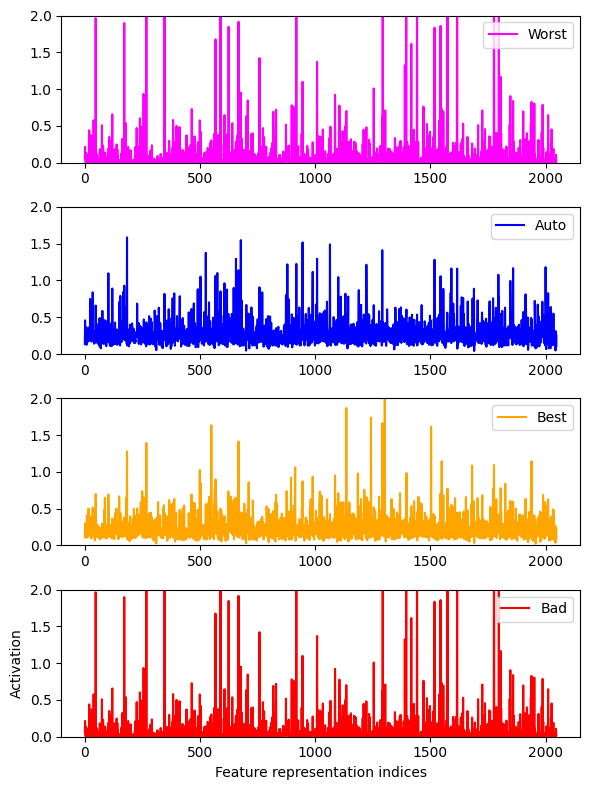

In [13]:
from utils.qualitatives import N

TARGET_ENV = 'l2'
interest_settings = fc.get_interest_settings(TARGET_ENV)                      

BEST_SETTING = interest_settings[f'BEST{N}_SETTING'][0]
WORST_SETTING = interest_settings[f'WORST{N}_SETTING'][0]
MAL_SETTING = interest_settings[f'WORST{N}_SETTING'][0]
AUTO_SETTING = interest_settings['AUTO5_SETTING'][0]

data_b = fvs['param-control'][TARGET_ENV][BEST_SETTING]
data_w = fvs['param-control'][TARGET_ENV][WORST_SETTING]
data_m = fvs['param-control'][TARGET_ENV][WORST_SETTING]
data_a = fvs['auto-exposure'][TARGET_ENV][AUTO_SETTING]

activations = {
    'worst': data_w,
    'auto': data_a,
    'best': data_b,
    'mal': data_m
}

fc.plot_activation_dist(activations, f'{QUAL_DIR}/fv-distributions.png') # 저장 경로 문제 해결필요

# Feature Embeddings

In [ ]:
TARGET_ENV = 'l1'
interest_settings_l1 = fc.get_interest_settings(TARGET_ENV)
b_l1 = interest_settings_l1['BEST5_SETTING']
w_l1 = interest_settings_l1['WORST5_SETTING']
a_l1 = interest_settings_l1['AUTO5_SETTING']

TARGET_ENV = 'l5'
interest_settings_l5 = fc.get_interest_settings(TARGET_ENV)
b_l5 = interest_settings_l5['BEST5_SETTING']
w_l5 = interest_settings_l5['WORST5_SETTING']
a_l5 = interest_settings_l5['AUTO5_SETTING']

data_b = [fvs['param-control']['l1'][setting] for setting in b_l1] + [fvs['param-control']['l1'][setting] for setting in b_l5] 
data_w = [fvs['param-control']['l1'][setting] for setting in w_l1] + [fvs['param-control']['l1'][setting] for setting in w_l5] 
data_a = sum([[fvs['auto-exposure'][env][f'param_{n}'] for n in range(1,5+1)] for env in ['l1','l5']], [])

data = {
    'best': data_b,
    'worst': data_w,
    'auto': data_a,
}

fc.draw_multiple_embeddings(data, file_name=f'{QUAL_DIR}/embeddings.png')

# Parameter Grid Plot 

In [ ]:
from utils.grid_analysis import GridCanvas

log_file = 'log.pickle'
gc = GridCanvas(log_file)
accs_info = ch.load('./DG_results/sensor_control.pt')
gc.draw_grid_plots(accs_info, ['resnet50', 'Swin-B', 'DINOv2'], file_name=f'{QUAL_DIR}/model-wise-grid-plots-l1.png')

In [ ]:
res_l1_accs = ch.load(f'./DG_results/class-wise-accs_{"res50"}.pt')['l1']
target_indices = ['n03026506' ,'n03404251', 'n02917067', 'n02236044', 'n02950826']
gc.draw_class_wise_grid_plots(res_l1_accs, file_name=f'{QUAL_DIR}/res50_class-wise-representatives.png', targets=target_indices, figsize=(19,3), rc=(1,6))